In [2]:
from IPython.display import display, HTML
p="Flatness Vs Generalization Part 2:"
html_markup="<h1>" +p+ "</h1>"
display(HTML(html_markup))

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
def data_loader(train_batch_size, test_batch_size):
    train_data = torch.utils.data.DataLoader(
        datasets.MNIST('data', train = True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor()
                       ])),
        batch_size = train_batch_size, shuffle=True)

    test_data = torch.utils.data.DataLoader(
        datasets.MNIST('data', train = False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor()
        ])),
        batch_size = test_batch_size, shuffle=True)

    return (train_data, test_data)
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.linear1 = nn.Linear(16 * 5 * 5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = x.view(x.size()[0], -1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))

        x = self.linear3(x)
        return x
def sensitivity(model):
    fNormTotal = 0
    counter = 0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = p.grad
            fNorm = torch.linalg.norm(grad).numpy()
            fNormTotal += fNorm
            counter += 1
    return fNormTotal / counter
def init_optimizer(model):
    return optim.SGD(model.parameters(), lr=1e-2)
def train(model, optimizer, data):
    model.train()
    for batch_idx, (data, target) in enumerate(data):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        output = model(data)
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
def calculate_op_diff(model, loader):
    correct = 0
    total = 0
    costTotal = 0
    costCounter = 0
    loss_fn = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = model(data)
            cost = loss_fn(output, target)
            costTotal += cost
            costCounter += 1
            for i, outputTensor in enumerate(output):
                if torch.argmax(outputTensor) == target[i]:
                    correct += 1
                total += 1
    return costTotal / costCounter, round(correct/total, 3)
epochs=40
param_arr = []
train_loss_arr = []
test_loss_arr = []
train_accuracy_arr = []
test_accuracy_arr = []

def train_models(model, optimizer, train_data, test_data):
    total_train_loss = 0
    print('Training model ')
    for epoch in range(1, epochs + 1):
        print('Training epoch - ' , epoch)
        train(model, optimizer, train_data)
    train_loss, train_acc = calculate_op_diff(model, train_data)
    test_loss, test_acc = calculate_op_diff(model, test_data)

    train_loss_arr.append(train_loss)
    test_loss_arr.append(test_loss)
    train_accuracy_arr.append(train_acc)
    test_accuracy_arr.append(test_acc)
#         param_arr.append(calculate_parameters('Model params',  model))
    print('test loss - ', test_loss, ' epoch - ', epoch)
    print('Training completed..')
#     return train_loss_arr, test_loss_arr, train_accuracy_arr, test_accuracy_arr, param_arr
batch_arr = [150, 250, 750, 4000, 8000]
sensitivity_arr= []
for batch in batch_arr:
    train_data, test_data = data_loader(batch, batch)
    model = Model()
    optimizer = init_optimizer(model)
    train_models(model, optimizer, train_data, test_data)
    sensitivity_arr.append(sensitivity(model))


Training model 
Training epoch -  1
Training epoch -  2
Training epoch -  3
Training epoch -  4
Training epoch -  5
Training epoch -  6
Training epoch -  7
Training epoch -  8
Training epoch -  9
Training epoch -  10
Training epoch -  11
Training epoch -  12
Training epoch -  13
Training epoch -  14
Training epoch -  15
Training epoch -  16
Training epoch -  17
Training epoch -  18
Training epoch -  19
Training epoch -  20
Training epoch -  21
Training epoch -  22
Training epoch -  23
Training epoch -  24
Training epoch -  25
Training epoch -  26
Training epoch -  27
Training epoch -  28
Training epoch -  29
Training epoch -  30
Training epoch -  31
Training epoch -  32
Training epoch -  33
Training epoch -  34
Training epoch -  35
Training epoch -  36
Training epoch -  37
Training epoch -  38
Training epoch -  39
Training epoch -  40
test loss -  tensor(0.0390)  epoch -  40
Training completed..
Training model 
Training epoch -  1
Training epoch -  2
Training epoch -  3
Training epoch 

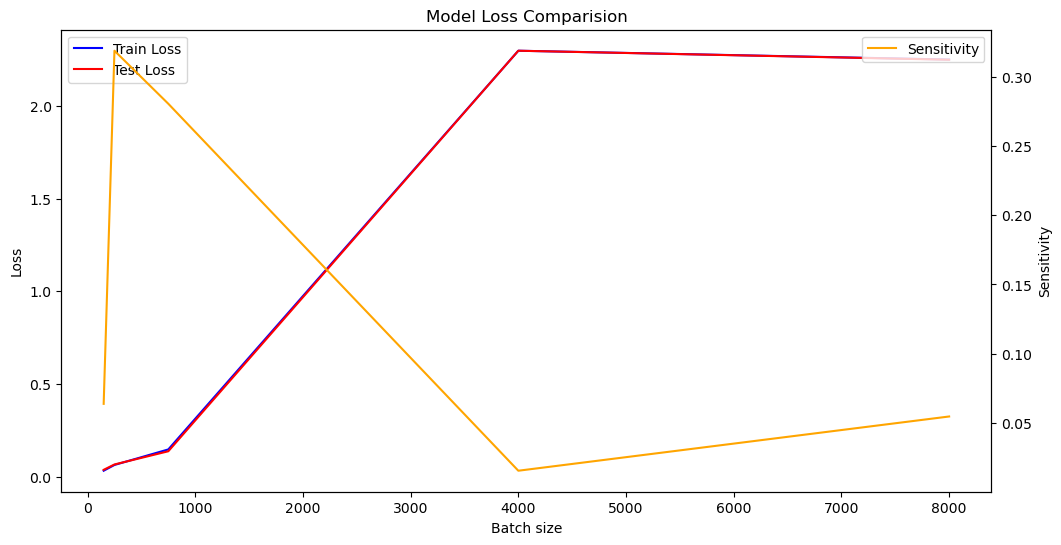

In [4]:
plt.figure(figsize=(12,8))
plt.plot(batch_arr, train_loss_arr, color = "blue")
plt.plot(batch_arr, test_loss_arr, color = "red")
plt.xlabel('Batch size')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])

ax2 = plt.twinx()

plt.plot(batch_arr, sensitivity_arr, color = "orange")
plt.title('Model Loss Comparision')
plt.legend(['Sensitivity'])
plt.ylabel('Sensitivity')
plt.show()

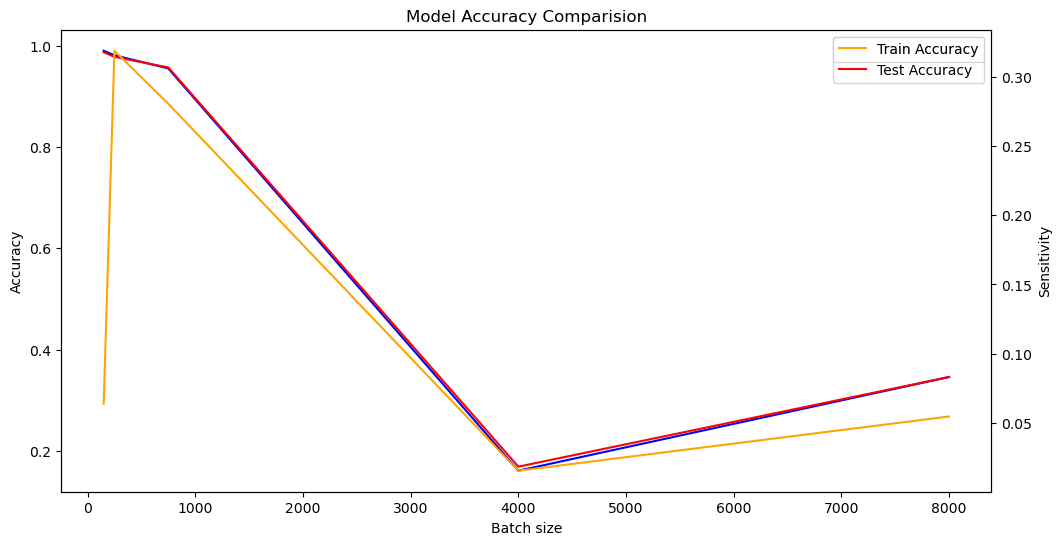

In [5]:
plt.figure(figsize=(12,8))
plt.plot(batch_arr, train_accuracy_arr, color = "blue")
plt.plot(batch_arr, test_accuracy_arr, color = "red")
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])

ax2 = plt.twinx()

plt.plot(batch_arr, sensitivity_arr, color = "orange")
plt.title('Model Accuracy Comparision')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Sensitivity'])
plt.ylabel('Sensitivity')
plt.show()